# PREDICTION OF THE FLOW OF PEOPLE AT STATIONS

This project aims to predict the flow of people at the principal stations of the NYC Subway. 

# 0 - IMPORTS

In [21]:
import pandas         as pd
import numpy          as np
import datetime       as dt
import seaborn        as sns
import datetime       as dt

from IPython.core.display      import HTML
from IPython.display           import Image

from sklearn.ensemble          import IsolationForest

## 0.1 - Helper functions

In [2]:
# Suppression of the scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Graph sets
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 - Loading data

Eight CSV files were provided to develop this project. Each one describes data from a specific year ranging from 2010 to 2017. Only the last three years will be considered (2015, 2016 and 2017). Excluding the others years is advantage because a smaller data will be used. The 8-year period is too long, so the last 3 years are the most important as they best represents the current reality of the stations.

In [8]:
# Loading the 3 csv files
df_15 = pd.read_csv('dataset/2015.csv')
df_16 = pd.read_csv('dataset/2016.csv')
df_17 = pd.read_csv('dataset/2017.csv')

# Concatenating the data
df = pd.concat([df_15, df_16, df_17], ignore_index=True)

## 0.3 - Pre-setting of the dataset

In [9]:
# Creating the 'turnstile' column
df['turnstile'] = df['division'] + '_' + df['station'] + '_' + df['linename'] + '_' + df['unit'] + '_' + df['ca'] + '_' + df['scp']

# Replacing the station and turnstiles values with numbers
## station
id_station = df.copy()
id_station = id_station.drop_duplicates(subset='station', keep='first')['station'].reset_index().reset_index()
id_station = id_station.drop('index', axis=1)
id_station.columns = ['id_station', 'station']

df = pd.merge(df, id_station, how='left', on='station')

## turnstile
id_turnstile = df.copy()
id_turnstile = id_turnstile.drop_duplicates(subset='turnstile', keep='first')['turnstile'].reset_index().reset_index()
id_turnstile = id_turnstile.drop('index', axis=1)
id_turnstile.columns = ['id_turnstile', 'turnstile']

df = pd.merge(df, id_turnstile, how='left', on='turnstile')

df = df.drop(['station', 'turnstile'], axis=1).rename(columns={'id_station': 'station', 'id_turnstile': 'turnstile'}) # Dropping the old columns and renaming

## 0.4 - Response variable construction

The turnstiles have cumulatives values of 'entries' and 'exits' so it's necessary to organize the data to get the records of the same turnstile followed by the date and time. In this way it will be possible to calculate the difference between the records and obtain the flow of people through the sations.

In [10]:
df_aux1 = df.copy()
del df

### 0.4.1 - Calculating the difference between the turnstiles records

In [11]:
# Organizing the dataset by hierarchy
df_aux1 = df_aux1.sort_values(['turnstile', 'time']).reset_index(drop=True)
df_aux2 = df_aux1.groupby('turnstile')

# Calculating the difference between the turnstiles records
df_aux1['entries'] = df_aux2['entries'].transform(pd.Series.diff)
df_aux1['exits'] = df_aux2['exits'].transform(pd.Series.diff)

### 0.4.2 - Checking the values post transformation

In [12]:
# Checking the transformed values
print('Number of negative entries values: {}' .format(len(df_aux1['entries'][df_aux1['entries']<0])))
print('Number of negative exits values: {}' .format(len(df_aux1['exits'][df_aux1['exits']<0])))
print('Number of turnstiles: {}' .format(len(df_aux1['turnstile'].unique())))
print('Number of NaN rows: {}' .format(len(df_aux1[df_aux1['entries'].isnull()])))
print('Number of total rows: {}' .format(len(df_aux1['entries'])))

Number of negative entries values: 156407
Number of negative exits values: 114473
Number of turnstiles: 7373
Number of NaN rows: 7373
Number of total rows: 27652130


In [13]:
# Checking the distribution of the values of entries and exits
print('Distribution of the entries:\n{}' .format(df_aux1['entries'].describe()))
print('\nDistribution of the exits:\n{}' .format(df_aux1['exits'].describe()))

Distribution of the entries:
count      27644757.000
mean           3048.444
std         3283317.536
min     -2147369278.000
25%              10.000
50%              77.000
75%             246.000
max      2122355003.000
Name: entries, dtype: float64

Distribution of the exits:
count      27644757.000
mean           2671.289
std         3095444.710
min     -2097169658.000
25%               8.000
50%              52.000
75%             165.000
max      2088918777.000
Name: exits, dtype: float64


### 0.4.3 - Removing problems caused by transformation

**COMMENT:** There are outliers in the dataset as could see comparing the third quartile to the max value, so they will be set to 0 ( > 6000). The negative values happen due the bad record moment by the turnstile. They represent 0.49% of the dataset rows, do they will be set to 0. The NaN values means the intial record of the turnstile, so they will be set to 0.

In [14]:
# Eliminating the problem rows of the dataset
df_aux1[df_aux1['entries'] < 0] = 0
df_aux1['entries'] = df_aux1['entries'].fillna(0)
df_aux1[df_aux1['entries'] > 6000] = 0 # Removing outliers

df_aux1[df_aux1['exits'] < 0] = 0
df_aux1['exits'] = df_aux1['exits'].fillna(0)
df_aux1[df_aux1['exits'] > 6000] = 0 # Removing outliers

### 0.4.4 - Creation of the variable response: 'flow'

In [15]:
# Creation of the 'flow' column
df_aux1['flow'] = df_aux1['entries'] + df_aux1['exits']

# Drop 'entries' and 'exits' columns
df_aux1 = df_aux1.drop(['entries', 'exits'], axis=1)

## 0.5 - Final dataset adjustment

In [16]:
df = df_aux1.copy()

### 0.5.1 - Getting 'date' column and grouping data by date

In [17]:
# Split 'time' column into 'date' and 'time'
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# Drop columns
df = df.drop(['time', 'scp', 'desc'], axis=1)

# Grouping the dataset by 'date'
df = df[['ca', 'unit', 'linename', 'division', 'station', 'turnstile', 'date', 'flow']].groupby(['ca', 'unit', 'linename', 'division', 'station','turnstile', 'date']).sum().reset_index()

### 0.5.2 - Identify outliers by IsolationForest

To check the variable response random turnstiles will be selected and observed by graphics. The IsolationForest will be applied as outlier selector method.

In [18]:
# Remove rows with 0 value for 'flow'
df = df[df['flow']>0]

In [22]:
# Identify outliers by IsolationForest
list_tst = df['turnstile'].unique()
size = len(list_tst)
df_x = df[df['turnstile']==123456789].copy()
iforest = IsolationForest(contamination=0.01)

j = 1
for i in list_tst:
    df_y = df[df['turnstile']==i].copy()

    iforest.fit(df_y[['flow']].values)
    df_y['scores']=iforest.decision_function(df_y[['flow']].values)
    df_y['anomaly']=iforest.predict(df_y[['flow']].values)
    
    mean_ = df_y['flow'].mean()
    if mean_ >= 100:
        df_y['anomaly'] = df_y[['flow', 'anomaly']].apply(lambda x: -2 if (x['flow']<=0.1*mean_) & (x['anomaly']==1) else
                                                                    -1 if (x['anomaly']==-1) else 1, axis=1)
    
    df_x = pd.concat([df_x, df_y])
    print('{} / {}'.format(j, size))
    j = j+1

1 / 7326
2 / 7326
3 / 7326
4 / 7326
5 / 7326
6 / 7326
7 / 7326
8 / 7326
9 / 7326
10 / 7326
11 / 7326
12 / 7326
13 / 7326
14 / 7326
15 / 7326
16 / 7326
17 / 7326
18 / 7326
19 / 7326
20 / 7326
21 / 7326
22 / 7326
23 / 7326
24 / 7326
25 / 7326
26 / 7326
27 / 7326
28 / 7326
29 / 7326
30 / 7326
31 / 7326
32 / 7326
33 / 7326
34 / 7326
35 / 7326
36 / 7326
37 / 7326
38 / 7326
39 / 7326
40 / 7326
41 / 7326
42 / 7326
43 / 7326
44 / 7326
45 / 7326
46 / 7326
47 / 7326
48 / 7326
49 / 7326
50 / 7326
51 / 7326
52 / 7326
53 / 7326
54 / 7326
55 / 7326
56 / 7326
57 / 7326
58 / 7326
59 / 7326
60 / 7326
61 / 7326
62 / 7326
63 / 7326
64 / 7326
65 / 7326
66 / 7326
67 / 7326
68 / 7326
69 / 7326
70 / 7326
71 / 7326
72 / 7326
73 / 7326
74 / 7326
75 / 7326
76 / 7326
77 / 7326
78 / 7326
79 / 7326
80 / 7326
81 / 7326
82 / 7326
83 / 7326
84 / 7326
85 / 7326
86 / 7326
87 / 7326
88 / 7326
89 / 7326
90 / 7326
91 / 7326
92 / 7326
93 / 7326
94 / 7326
95 / 7326
96 / 7326
97 / 7326
98 / 7326
99 / 7326
100 / 7326
101 / 73

756 / 7326
757 / 7326
758 / 7326
759 / 7326
760 / 7326
761 / 7326
762 / 7326
763 / 7326
764 / 7326
765 / 7326
766 / 7326
767 / 7326
768 / 7326
769 / 7326
770 / 7326
771 / 7326
772 / 7326
773 / 7326
774 / 7326
775 / 7326
776 / 7326
777 / 7326
778 / 7326
779 / 7326
780 / 7326
781 / 7326
782 / 7326
783 / 7326
784 / 7326
785 / 7326
786 / 7326
787 / 7326
788 / 7326
789 / 7326
790 / 7326
791 / 7326
792 / 7326
793 / 7326
794 / 7326
795 / 7326
796 / 7326
797 / 7326
798 / 7326
799 / 7326
800 / 7326
801 / 7326
802 / 7326
803 / 7326
804 / 7326
805 / 7326
806 / 7326
807 / 7326
808 / 7326
809 / 7326
810 / 7326
811 / 7326
812 / 7326
813 / 7326
814 / 7326
815 / 7326
816 / 7326
817 / 7326
818 / 7326
819 / 7326
820 / 7326
821 / 7326
822 / 7326
823 / 7326
824 / 7326
825 / 7326
826 / 7326
827 / 7326
828 / 7326
829 / 7326
830 / 7326
831 / 7326
832 / 7326
833 / 7326
834 / 7326
835 / 7326
836 / 7326
837 / 7326
838 / 7326
839 / 7326
840 / 7326
841 / 7326
842 / 7326
843 / 7326
844 / 7326
845 / 7326
846 / 7326

1460 / 7326
1461 / 7326
1462 / 7326
1463 / 7326
1464 / 7326
1465 / 7326
1466 / 7326
1467 / 7326
1468 / 7326
1469 / 7326
1470 / 7326
1471 / 7326
1472 / 7326
1473 / 7326
1474 / 7326
1475 / 7326
1476 / 7326
1477 / 7326
1478 / 7326
1479 / 7326
1480 / 7326
1481 / 7326
1482 / 7326
1483 / 7326
1484 / 7326
1485 / 7326
1486 / 7326
1487 / 7326
1488 / 7326
1489 / 7326
1490 / 7326
1491 / 7326
1492 / 7326
1493 / 7326
1494 / 7326
1495 / 7326
1496 / 7326
1497 / 7326
1498 / 7326
1499 / 7326
1500 / 7326
1501 / 7326
1502 / 7326
1503 / 7326
1504 / 7326
1505 / 7326
1506 / 7326
1507 / 7326
1508 / 7326
1509 / 7326
1510 / 7326
1511 / 7326
1512 / 7326
1513 / 7326
1514 / 7326
1515 / 7326
1516 / 7326
1517 / 7326
1518 / 7326
1519 / 7326
1520 / 7326
1521 / 7326
1522 / 7326
1523 / 7326
1524 / 7326
1525 / 7326
1526 / 7326
1527 / 7326
1528 / 7326
1529 / 7326
1530 / 7326
1531 / 7326
1532 / 7326
1533 / 7326
1534 / 7326
1535 / 7326
1536 / 7326
1537 / 7326
1538 / 7326
1539 / 7326
1540 / 7326
1541 / 7326
1542 / 7326
1543

2143 / 7326
2144 / 7326
2145 / 7326
2146 / 7326
2147 / 7326
2148 / 7326
2149 / 7326
2150 / 7326
2151 / 7326
2152 / 7326
2153 / 7326
2154 / 7326
2155 / 7326
2156 / 7326
2157 / 7326
2158 / 7326
2159 / 7326
2160 / 7326
2161 / 7326
2162 / 7326
2163 / 7326
2164 / 7326
2165 / 7326
2166 / 7326
2167 / 7326
2168 / 7326
2169 / 7326
2170 / 7326
2171 / 7326
2172 / 7326
2173 / 7326
2174 / 7326
2175 / 7326
2176 / 7326
2177 / 7326
2178 / 7326
2179 / 7326
2180 / 7326
2181 / 7326
2182 / 7326
2183 / 7326
2184 / 7326
2185 / 7326
2186 / 7326
2187 / 7326
2188 / 7326
2189 / 7326
2190 / 7326
2191 / 7326
2192 / 7326
2193 / 7326
2194 / 7326
2195 / 7326
2196 / 7326
2197 / 7326
2198 / 7326
2199 / 7326
2200 / 7326
2201 / 7326
2202 / 7326
2203 / 7326
2204 / 7326
2205 / 7326
2206 / 7326
2207 / 7326
2208 / 7326
2209 / 7326
2210 / 7326
2211 / 7326
2212 / 7326
2213 / 7326
2214 / 7326
2215 / 7326
2216 / 7326
2217 / 7326
2218 / 7326
2219 / 7326
2220 / 7326
2221 / 7326
2222 / 7326
2223 / 7326
2224 / 7326
2225 / 7326
2226

2826 / 7326
2827 / 7326
2828 / 7326
2829 / 7326
2830 / 7326
2831 / 7326
2832 / 7326
2833 / 7326
2834 / 7326
2835 / 7326
2836 / 7326
2837 / 7326
2838 / 7326
2839 / 7326
2840 / 7326
2841 / 7326
2842 / 7326
2843 / 7326
2844 / 7326
2845 / 7326
2846 / 7326
2847 / 7326
2848 / 7326
2849 / 7326
2850 / 7326
2851 / 7326
2852 / 7326
2853 / 7326
2854 / 7326
2855 / 7326
2856 / 7326
2857 / 7326
2858 / 7326
2859 / 7326
2860 / 7326
2861 / 7326
2862 / 7326
2863 / 7326
2864 / 7326
2865 / 7326
2866 / 7326
2867 / 7326
2868 / 7326
2869 / 7326
2870 / 7326
2871 / 7326
2872 / 7326
2873 / 7326
2874 / 7326
2875 / 7326
2876 / 7326
2877 / 7326
2878 / 7326
2879 / 7326
2880 / 7326
2881 / 7326
2882 / 7326
2883 / 7326
2884 / 7326
2885 / 7326
2886 / 7326
2887 / 7326
2888 / 7326
2889 / 7326
2890 / 7326
2891 / 7326
2892 / 7326
2893 / 7326
2894 / 7326
2895 / 7326
2896 / 7326
2897 / 7326
2898 / 7326
2899 / 7326
2900 / 7326
2901 / 7326
2902 / 7326
2903 / 7326
2904 / 7326
2905 / 7326
2906 / 7326
2907 / 7326
2908 / 7326
2909

3509 / 7326
3510 / 7326
3511 / 7326
3512 / 7326
3513 / 7326
3514 / 7326
3515 / 7326
3516 / 7326
3517 / 7326
3518 / 7326
3519 / 7326
3520 / 7326
3521 / 7326
3522 / 7326
3523 / 7326
3524 / 7326
3525 / 7326
3526 / 7326
3527 / 7326
3528 / 7326
3529 / 7326
3530 / 7326
3531 / 7326
3532 / 7326
3533 / 7326
3534 / 7326
3535 / 7326
3536 / 7326
3537 / 7326
3538 / 7326
3539 / 7326
3540 / 7326
3541 / 7326
3542 / 7326
3543 / 7326
3544 / 7326
3545 / 7326
3546 / 7326
3547 / 7326
3548 / 7326
3549 / 7326
3550 / 7326
3551 / 7326
3552 / 7326
3553 / 7326
3554 / 7326
3555 / 7326
3556 / 7326
3557 / 7326
3558 / 7326
3559 / 7326
3560 / 7326
3561 / 7326
3562 / 7326
3563 / 7326
3564 / 7326
3565 / 7326
3566 / 7326
3567 / 7326
3568 / 7326
3569 / 7326
3570 / 7326
3571 / 7326
3572 / 7326
3573 / 7326
3574 / 7326
3575 / 7326
3576 / 7326
3577 / 7326
3578 / 7326
3579 / 7326
3580 / 7326
3581 / 7326
3582 / 7326
3583 / 7326
3584 / 7326
3585 / 7326
3586 / 7326
3587 / 7326
3588 / 7326
3589 / 7326
3590 / 7326
3591 / 7326
3592

4192 / 7326
4193 / 7326
4194 / 7326
4195 / 7326
4196 / 7326
4197 / 7326
4198 / 7326
4199 / 7326
4200 / 7326
4201 / 7326
4202 / 7326
4203 / 7326
4204 / 7326
4205 / 7326
4206 / 7326
4207 / 7326
4208 / 7326
4209 / 7326
4210 / 7326
4211 / 7326
4212 / 7326
4213 / 7326
4214 / 7326
4215 / 7326
4216 / 7326
4217 / 7326
4218 / 7326
4219 / 7326
4220 / 7326
4221 / 7326
4222 / 7326
4223 / 7326
4224 / 7326
4225 / 7326
4226 / 7326
4227 / 7326
4228 / 7326
4229 / 7326
4230 / 7326
4231 / 7326
4232 / 7326
4233 / 7326
4234 / 7326
4235 / 7326
4236 / 7326
4237 / 7326
4238 / 7326
4239 / 7326
4240 / 7326
4241 / 7326
4242 / 7326
4243 / 7326
4244 / 7326
4245 / 7326
4246 / 7326
4247 / 7326
4248 / 7326
4249 / 7326
4250 / 7326
4251 / 7326
4252 / 7326
4253 / 7326
4254 / 7326
4255 / 7326
4256 / 7326
4257 / 7326
4258 / 7326
4259 / 7326
4260 / 7326
4261 / 7326
4262 / 7326
4263 / 7326
4264 / 7326
4265 / 7326
4266 / 7326
4267 / 7326
4268 / 7326
4269 / 7326
4270 / 7326
4271 / 7326
4272 / 7326
4273 / 7326
4274 / 7326
4275

4875 / 7326
4876 / 7326
4877 / 7326
4878 / 7326
4879 / 7326
4880 / 7326
4881 / 7326
4882 / 7326
4883 / 7326
4884 / 7326
4885 / 7326
4886 / 7326
4887 / 7326
4888 / 7326
4889 / 7326
4890 / 7326
4891 / 7326
4892 / 7326
4893 / 7326
4894 / 7326
4895 / 7326
4896 / 7326
4897 / 7326
4898 / 7326
4899 / 7326
4900 / 7326
4901 / 7326
4902 / 7326
4903 / 7326
4904 / 7326
4905 / 7326
4906 / 7326
4907 / 7326
4908 / 7326
4909 / 7326
4910 / 7326
4911 / 7326
4912 / 7326
4913 / 7326
4914 / 7326
4915 / 7326
4916 / 7326
4917 / 7326
4918 / 7326
4919 / 7326
4920 / 7326
4921 / 7326
4922 / 7326
4923 / 7326
4924 / 7326
4925 / 7326
4926 / 7326
4927 / 7326
4928 / 7326
4929 / 7326
4930 / 7326
4931 / 7326
4932 / 7326
4933 / 7326
4934 / 7326
4935 / 7326
4936 / 7326
4937 / 7326
4938 / 7326
4939 / 7326
4940 / 7326
4941 / 7326
4942 / 7326
4943 / 7326
4944 / 7326
4945 / 7326
4946 / 7326
4947 / 7326
4948 / 7326
4949 / 7326
4950 / 7326
4951 / 7326
4952 / 7326
4953 / 7326
4954 / 7326
4955 / 7326
4956 / 7326
4957 / 7326
4958

5558 / 7326
5559 / 7326
5560 / 7326
5561 / 7326
5562 / 7326
5563 / 7326
5564 / 7326
5565 / 7326
5566 / 7326
5567 / 7326
5568 / 7326
5569 / 7326
5570 / 7326
5571 / 7326
5572 / 7326
5573 / 7326
5574 / 7326
5575 / 7326
5576 / 7326
5577 / 7326
5578 / 7326
5579 / 7326
5580 / 7326
5581 / 7326
5582 / 7326
5583 / 7326
5584 / 7326
5585 / 7326
5586 / 7326
5587 / 7326
5588 / 7326
5589 / 7326
5590 / 7326
5591 / 7326
5592 / 7326
5593 / 7326
5594 / 7326
5595 / 7326
5596 / 7326
5597 / 7326
5598 / 7326
5599 / 7326
5600 / 7326
5601 / 7326
5602 / 7326
5603 / 7326
5604 / 7326
5605 / 7326
5606 / 7326
5607 / 7326
5608 / 7326
5609 / 7326
5610 / 7326
5611 / 7326
5612 / 7326
5613 / 7326
5614 / 7326
5615 / 7326
5616 / 7326
5617 / 7326
5618 / 7326
5619 / 7326
5620 / 7326
5621 / 7326
5622 / 7326
5623 / 7326
5624 / 7326
5625 / 7326
5626 / 7326
5627 / 7326
5628 / 7326
5629 / 7326
5630 / 7326
5631 / 7326
5632 / 7326
5633 / 7326
5634 / 7326
5635 / 7326
5636 / 7326
5637 / 7326
5638 / 7326
5639 / 7326
5640 / 7326
5641

6241 / 7326
6242 / 7326
6243 / 7326
6244 / 7326
6245 / 7326
6246 / 7326
6247 / 7326
6248 / 7326
6249 / 7326
6250 / 7326
6251 / 7326
6252 / 7326
6253 / 7326
6254 / 7326
6255 / 7326
6256 / 7326
6257 / 7326
6258 / 7326
6259 / 7326
6260 / 7326
6261 / 7326
6262 / 7326
6263 / 7326
6264 / 7326
6265 / 7326
6266 / 7326
6267 / 7326
6268 / 7326
6269 / 7326
6270 / 7326
6271 / 7326
6272 / 7326
6273 / 7326
6274 / 7326
6275 / 7326
6276 / 7326
6277 / 7326
6278 / 7326
6279 / 7326
6280 / 7326
6281 / 7326
6282 / 7326
6283 / 7326
6284 / 7326
6285 / 7326
6286 / 7326
6287 / 7326
6288 / 7326
6289 / 7326
6290 / 7326
6291 / 7326
6292 / 7326
6293 / 7326
6294 / 7326
6295 / 7326
6296 / 7326
6297 / 7326
6298 / 7326
6299 / 7326
6300 / 7326
6301 / 7326
6302 / 7326
6303 / 7326
6304 / 7326
6305 / 7326
6306 / 7326
6307 / 7326
6308 / 7326
6309 / 7326
6310 / 7326
6311 / 7326
6312 / 7326
6313 / 7326
6314 / 7326
6315 / 7326
6316 / 7326
6317 / 7326
6318 / 7326
6319 / 7326
6320 / 7326
6321 / 7326
6322 / 7326
6323 / 7326
6324

6924 / 7326
6925 / 7326
6926 / 7326
6927 / 7326
6928 / 7326
6929 / 7326
6930 / 7326
6931 / 7326
6932 / 7326
6933 / 7326
6934 / 7326
6935 / 7326
6936 / 7326
6937 / 7326
6938 / 7326
6939 / 7326
6940 / 7326
6941 / 7326
6942 / 7326
6943 / 7326
6944 / 7326
6945 / 7326
6946 / 7326
6947 / 7326
6948 / 7326
6949 / 7326
6950 / 7326
6951 / 7326
6952 / 7326
6953 / 7326
6954 / 7326
6955 / 7326
6956 / 7326
6957 / 7326
6958 / 7326
6959 / 7326
6960 / 7326
6961 / 7326
6962 / 7326
6963 / 7326
6964 / 7326
6965 / 7326
6966 / 7326
6967 / 7326
6968 / 7326
6969 / 7326
6970 / 7326
6971 / 7326
6972 / 7326
6973 / 7326
6974 / 7326
6975 / 7326
6976 / 7326
6977 / 7326
6978 / 7326
6979 / 7326
6980 / 7326
6981 / 7326
6982 / 7326
6983 / 7326
6984 / 7326
6985 / 7326
6986 / 7326
6987 / 7326
6988 / 7326
6989 / 7326
6990 / 7326
6991 / 7326
6992 / 7326
6993 / 7326
6994 / 7326
6995 / 7326
6996 / 7326
6997 / 7326
6998 / 7326
6999 / 7326
7000 / 7326
7001 / 7326
7002 / 7326
7003 / 7326
7004 / 7326
7005 / 7326
7006 / 7326
7007

In [23]:
# Select the three largest to analyze
turnstile = [537, 1526, 3543]

<AxesSubplot:xlabel='date', ylabel='flow'>

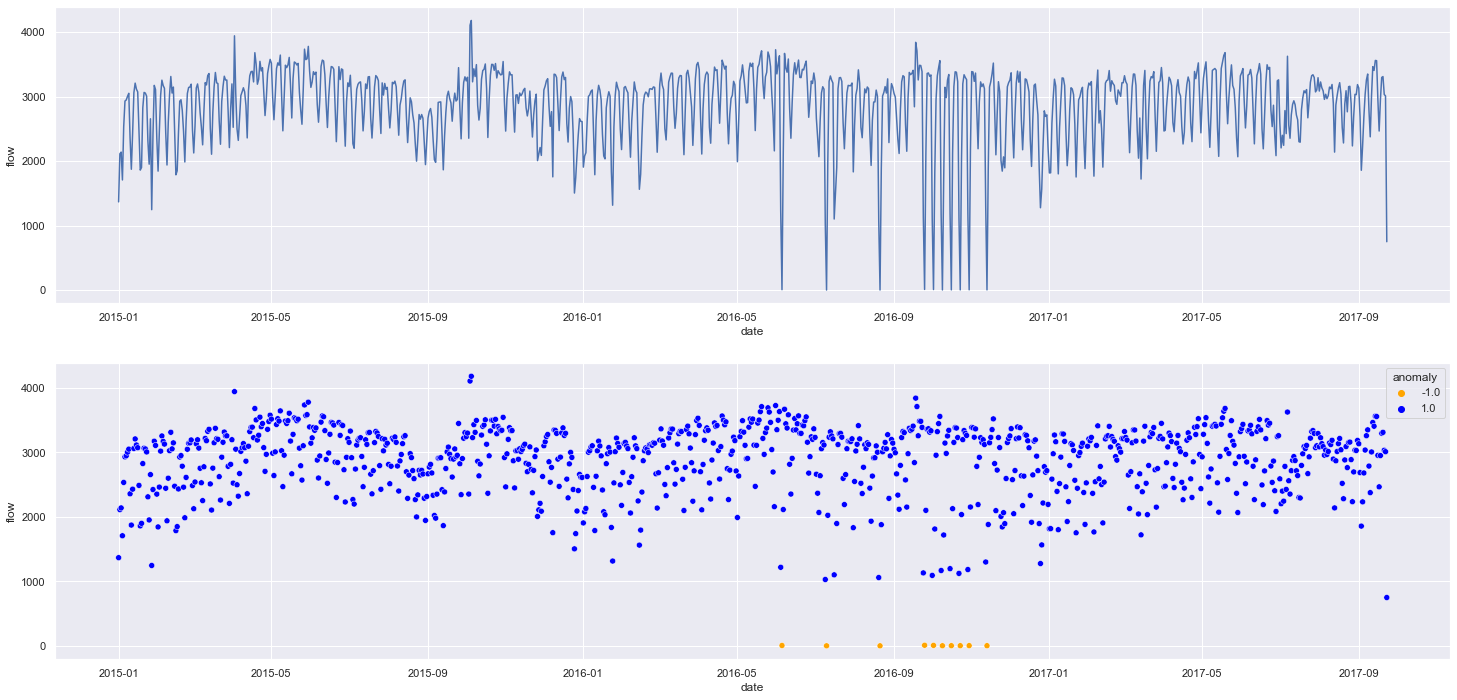

In [24]:
# turnstile 537
subplot(2,1,1)
aux = df[df['turnstile']==537]
sns.lineplot(x='date', y='flow', data=aux)
subplot(2,1,2)
aux1 = df_x[df_x['turnstile']==537]
sns.scatterplot(x='date', y='flow', data=aux1, hue='anomaly', palette=['orange', 'blue'])

<AxesSubplot:xlabel='date', ylabel='flow'>

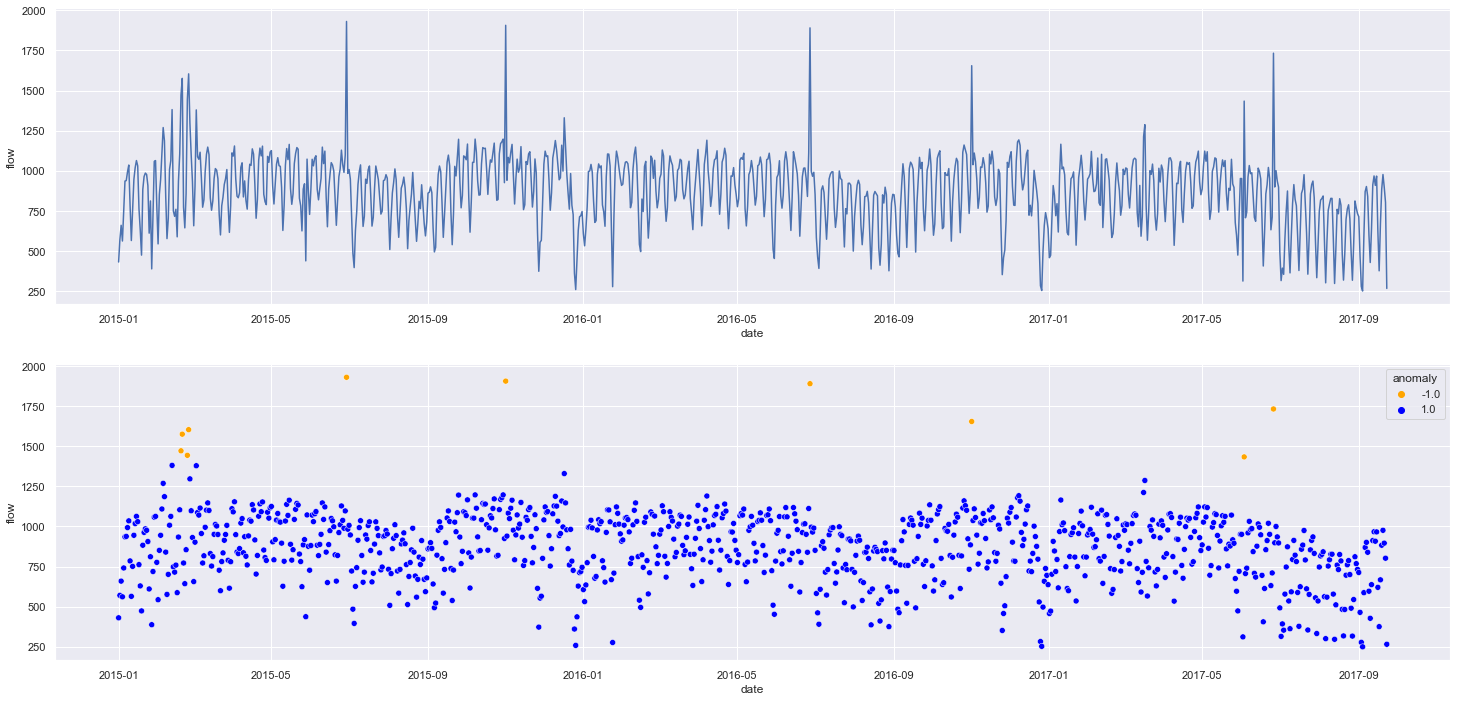

In [25]:
# turnstile 1526
subplot(2,1,1)
aux = df[df['turnstile']==turnstile[1]]
sns.lineplot(x='date', y='flow', data=aux)
subplot(2,1,2)
aux1 = df_x[df_x['turnstile']==turnstile[1]]
sns.scatterplot(x='date', y='flow', data=aux1, hue='anomaly', palette=['orange', 'blue'])

<AxesSubplot:xlabel='date', ylabel='flow'>

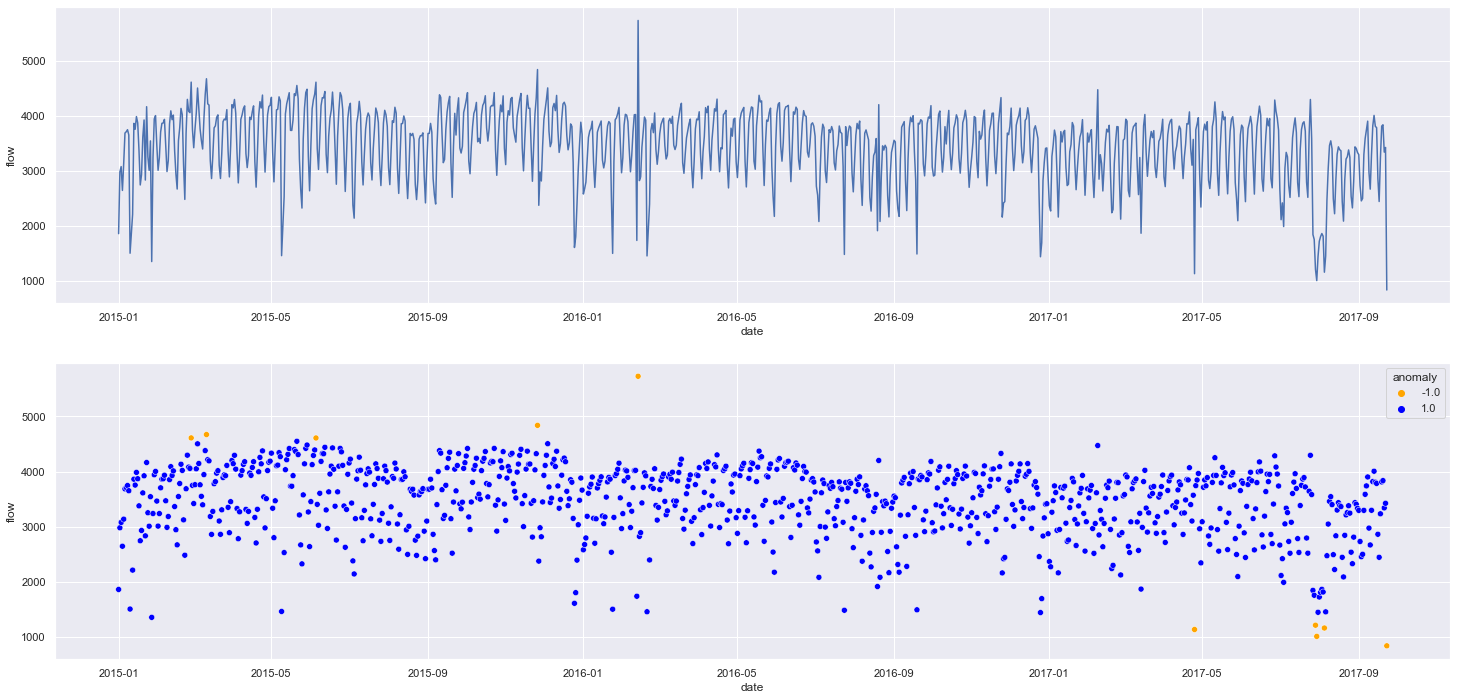

In [26]:
# turnstile 3543
subplot(2,1,1)
aux = df[df['turnstile']==turnstile[2]]
sns.lineplot(x='date', y='flow', data=aux)
subplot(2,1,2)
aux1 = df_x[df_x['turnstile']==turnstile[2]]
sns.scatterplot(x='date', y='flow', data=aux1, hue='anomaly', palette=['orange', 'blue'])

## 0.6 - Exporting the new dataframe to csv

In [27]:
df_x.to_csv('dataset/new_dataset.csv')

## 0.7 - Loading the new dataset

In [28]:
df = pd.read_csv('dataset/new_dataset.csv', low_memory=False)